In [2]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html
%load_ext autoreload
%autoreload 2
import os
import urllib.request
import pickle
import numpy as np
import cv2
from tools import *

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow, imread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Data

Images loaded.
Processing images..
X shape:  (3485, 66, 200, 3)
y shape:  (3485,)


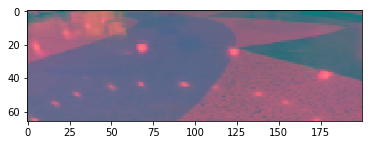

In [3]:
raw_X, raw_y = import_data('../inloop3')
print('Images loaded.')
print('Processing images..')
raw_X = np.array([process_image(item) for item in raw_X])
raw_X = normalize(raw_X)
print('X shape: ', raw_X.shape)
print('y shape: ', raw_y.shape)
imshow(raw_X[0])

In [4]:
shuffled_X, shuffled_y = shuffle_data(raw_X, raw_y)

In [5]:
train_X, train_y, val_X, val_y, test_X, test_y = split_data(shuffled_X, shuffled_y, 0.8, 0.1)

print('Train: ', len(train_X))
print('Val:   ', len(val_X))
print('Test:  ', len(test_X))
print('Total: ', len(train_X) + len(val_X) + len(test_X))

Train:  2788
Val:    348
Test:   349
Total:  3485


In [6]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

5576

In [7]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D

Using TensorFlow backend.


# Model used by William Roscoe for the Donkey SDC

In [11]:
model = Sequential()
model.add(Convolution2D(8, (3,3), input_shape=(66, 200, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('linear'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 198, 8)        224       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 198, 8)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 99, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 97, 16)        1168      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 97, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 48, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 46, 32)        4640      
__________

# Train

In [12]:
from keras import callbacks
model_path = os.getcwd() + '/models/donkey_model.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [14]:
model.fit(train_X, train_y, batch_size=128, epochs=30, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 5576 samples, validate on 348 samples
Epoch 1/30
5576/5576 [==============================] - 16s - loss: 0.1147 - val_loss: 0.0144
Epoch 2/30
5576/5576 [==============================] - 16s - loss: 0.0107 - val_loss: 0.0094
Epoch 3/30
5576/5576 [==============================] - 15s - loss: 0.0081 - val_loss: 0.0099
Epoch 4/30
5576/5576 [==============================] - 16s - loss: 0.0070 - val_loss: 0.0084
Epoch 5/30
5576/5576 [==============================] - 16s - loss: 0.0067 - val_loss: 0.0080
Epoch 6/30
5576/5576 [==============================] - 15s - loss: 0.0060 - val_loss: 0.0068
Epoch 7/30
5576/5576 [==============================] - 15s - loss: 0.0058 - val_loss: 0.0067
Epoch 8/30
5576/5576 [==============================] - 15s - loss: 0.0057 - val_loss: 0.0064
Epoch 9/30
5576/5576 [==============================] - 15s - loss: 0.0054 - val_loss: 0.0066
Epoch 10/30
5576/5576 [==============================] - 15s - loss: 0.0054 - val_loss: 0.0062
Epoch 11/30


# Evaluate

In [15]:
import pandas as pd
from keras.models import load_model
model = load_model(model_path)

# Test Data

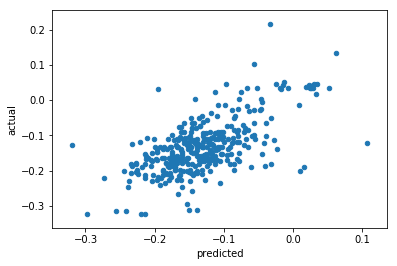

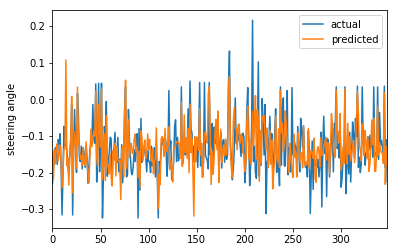

In [16]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape((pred_y.shape[0],))
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y})
ax = df.plot.scatter('predicted', 'actual')
ax2 = pd.DataFrame({'predicted':pred_y, 'actual':test_y}).plot()
ax2.set_ylabel('steering angle')

# Training Data

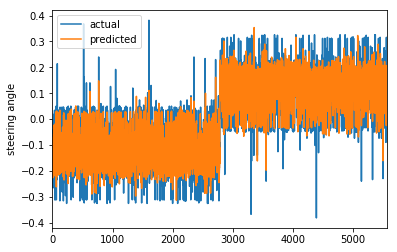

In [17]:
pred_y_2 = model.predict(train_X)
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':train_y}).plot()
ax.set_ylabel('steering angle')

In [20]:
print(model.predict(train_X[1:2]))
print(train_y[1])

[[-0.09758942]]
-0.064


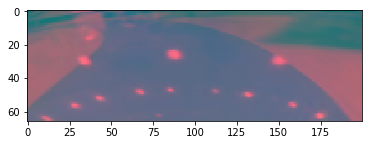

In [19]:
imshow(train_X[1])